In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Xopt class, TNK test function

This is the class method for running Xopt.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [2]:
# Import the class
from xopt import Xopt
import matplotlib.pyplot as plt
from botorch.utils.multi_objective.pareto import is_non_dominated
%matplotlib inline

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null, verbose: true}

algorithm:
  name: mobo
  options: 
    ref: [1.4, 1.4]
    n_initial_samples: 5
    n_steps: 10
    verbose: True      
    generator_options:
        batch_size: 4
  
simulation: 
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK  
  
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

In [5]:
# Optional: Connect the function directly
#from xopt.evaluators.test_TNK import evaluate_TNK 
#config['simulation']['evaluate'] = evaluate_TNK 
if SMOKE_TEST:
    config['algorithm']['options']['n_steps'] = 3
    config['algorithm']['options']['generator_options']['num_restarts'] = 2
    config['algorithm']['options']['generator_options']['raw_samples'] = 2


X = Xopt(config)
X

Loading config as dict.



            Xopt 
________________________________           
Version: 0.4.3+104.g5c5c916.dirty
Configured: True
Config as YAML:
xopt: {output_path: null, verbose: true, algorithm: cnsga}
algorithm:
  name: mobo
  function: xopt.bayesian.algorithms.mobo
  options:
    ref: [1.4, 1.4]
    n_initial_samples: 5
    n_steps: 10
    verbose: true
    generator_options: {batch_size: 4, num_restarts: 2, raw_samples: 2}
    custom_model: null
    restart_file: null
    initial_x: null
simulation:
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

# Run MOBO

MOBO is designed to run in serial or parallel

In [6]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

#executor = PoolExecutor()
# This will also work. 
executor=None

In [7]:
# Change max generations
X.run(executor=executor)

Starting at time 2021-09-01T10:32:27-05:00
started running optimization with generator: <xopt.bayesian.generators.mobo.MOBOGenerator object at 0x000002297F7A2610>
submitting initial candidates at time 2021-09-01T10:32:27-05:00
starting optimization loop
Model creation time: 0.504 s
Candidate generation time: 2.458 s
Candidate(s): tensor([[0.9007, 1.0433],
        [1.1426, 0.4312],
        [1.1934, 1.2739],
        [1.2095, 0.7600]], dtype=torch.float64)
submitting candidates at time 2021-09-01T10:32:30-05:00
Model creation time: 0.591 s
Candidate generation time: 2.192 s
Candidate(s): tensor([[0.2789, 0.0362],
        [0.0022, 0.0340],
        [1.2228, 1.2932],
        [1.4972, 0.8833]], dtype=torch.float64)
submitting candidates at time 2021-09-01T10:32:33-05:00
Model creation time: 0.5881 s
Candidate generation time: 0.4811 s
Candidate(s): tensor([[0.5137, 1.7520],
        [1.1543, 1.2923],
        [1.2113, 0.5141],
        [0.5444, 1.0362]], dtype=torch.float64)
submitting candidate

# Plot

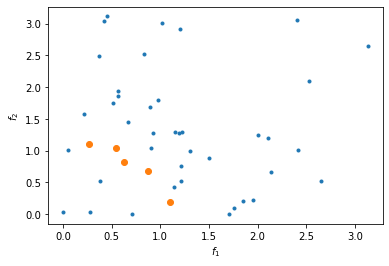

In [8]:
fig, ax = plt.subplots()

# get results and get valid observations
results = X.results
train_y = results['objectives']
valid_y = train_y[results['feasibility'].flatten()]

# plot results
ax.plot(train_y[:, 0], train_y[:, 1], '.')
ax.set_ylabel('$f_2$')
ax.set_xlabel('$f_1$')

# highlight Pareto front, ONLY using valid observations (note botorch assumes maximization when determing dominant points)
non_dom = is_non_dominated(-valid_y)
ax.plot(valid_y[:,0][non_dom],valid_y[:,1][non_dom],'C1o')

plt.show()